In [11]:
import os
import glob
import matplotlib.pyplot as plt
import json
import numpy as np
import cv2
import math
import scipy.misc
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from scipy.interpolate import splprep, splev
from tqdm import tqdm
from py_img_seg_eval import eval_segm
from scipy.ndimage.morphology import distance_transform_edt


def sigmoid(x, X5=0., X9=2.30, MAG=1.):
    """
    basically, based on sigmoid function.
    - ALPHA controls slope
    - at X5, sigmoid value is 0.5
    - at X9, sigmoid value is 0.9
    """
    x -= X5
    alpha = 2.30 / (X9-X5)
    return 1. / (1. + math.exp(- alpha * x)) * MAG

seg_bench_root = '/media/phantom/World/phantom_benchmark'
gt_path = os.path.join(seg_bench_root, 'segmentation', 'gt')

submission_path = os.path.join(seg_bench_root, 'segmentation', 'submissions', 'test')
submit_images = glob.glob(os.path.join(submission_path, '*.png'))

# Metric for a few images


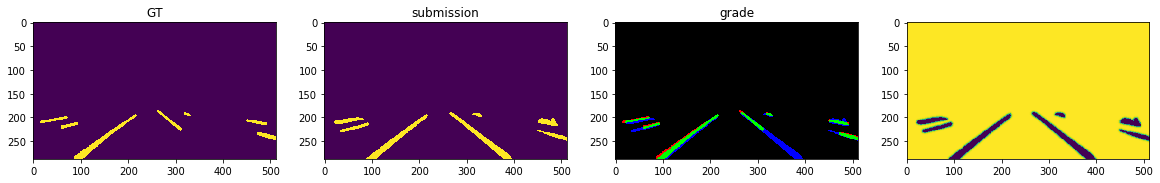

           pixel_accuracy 0.978576660156
            mean_accuracy 0.742975300822
    frequency_weighted_IU 0.959847124718
                  mean_IU 0.707706726115
          weighted recall 172.492084736


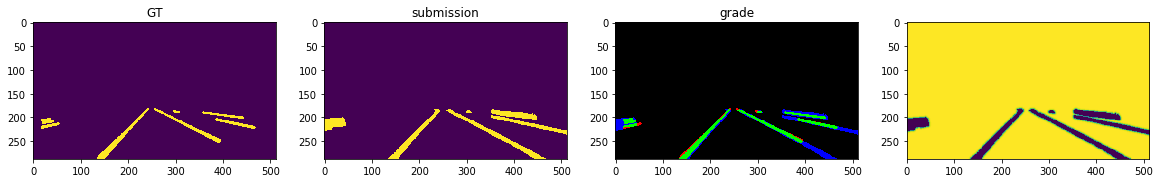

           pixel_accuracy 0.975246853299
            mean_accuracy 0.755211029029
    frequency_weighted_IU 0.952360356001
                  mean_IU 0.730356873281
          weighted recall 107.007816922


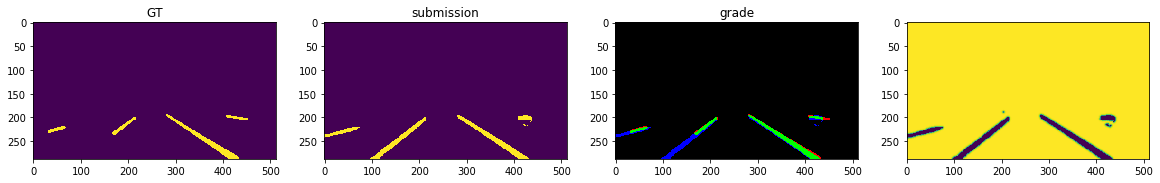

           pixel_accuracy 0.985710991753
            mean_accuracy 0.776802164331
    frequency_weighted_IU 0.972953562804
                  mean_IU 0.744400696598
          weighted recall 116.53838379


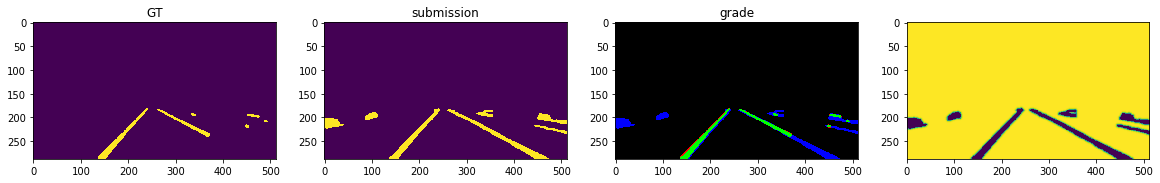

           pixel_accuracy 0.972893608941
            mean_accuracy 0.677766808372
    frequency_weighted_IU 0.947556885772
                  mean_IU 0.657821565551
          weighted recall 67.3117846644


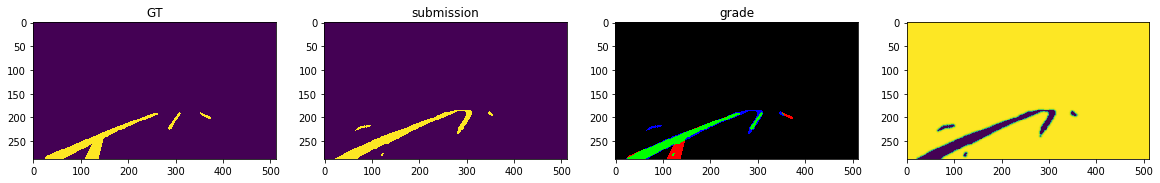

           pixel_accuracy 0.985100640191
            mean_accuracy 0.862377560544
    frequency_weighted_IU 0.973060537606
                  mean_IU 0.791080815682
          weighted recall 318.820125192


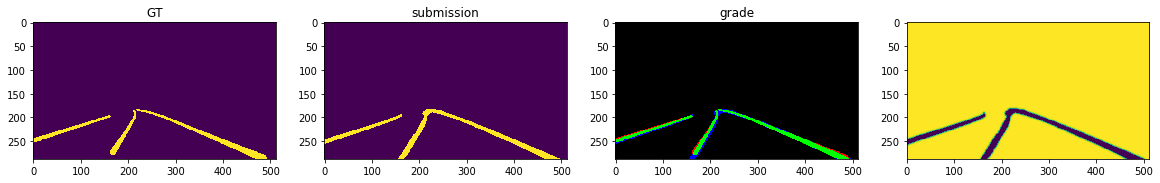

           pixel_accuracy 0.987453884549
            mean_accuracy 0.876000557055
    frequency_weighted_IU 0.976243877319
                  mean_IU 0.834673178244
          weighted recall 159.921995302


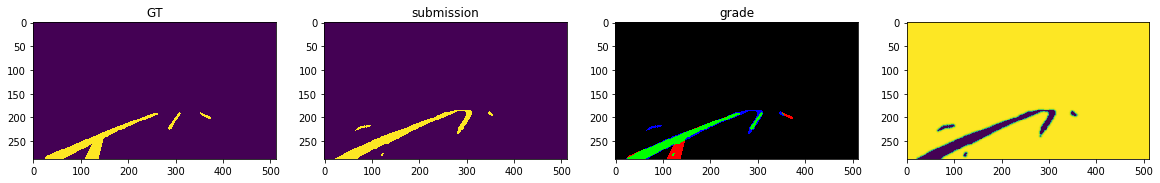

           pixel_accuracy 0.985100640191
            mean_accuracy 0.862377560544
    frequency_weighted_IU 0.973060537606
                  mean_IU 0.791080815682
          weighted recall 318.820125192


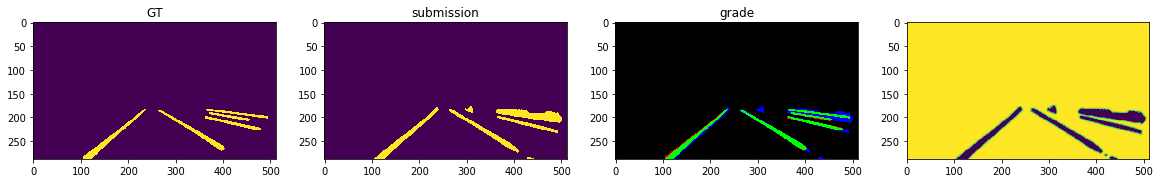

           pixel_accuracy 0.981397840712
            mean_accuracy 0.81700040207
    frequency_weighted_IU 0.964320804345
                  mean_IU 0.788002019867
          weighted recall 125.522311875


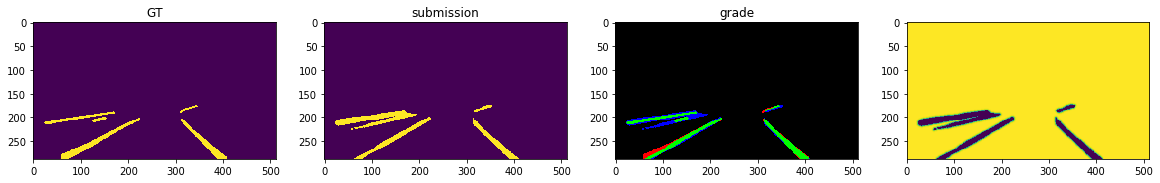

           pixel_accuracy 0.980916341146
            mean_accuracy 0.805004398416
    frequency_weighted_IU 0.964215466848
                  mean_IU 0.763808761546
          weighted recall 200.057106884


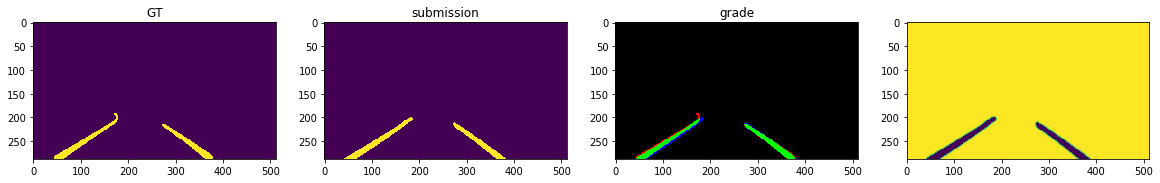

           pixel_accuracy 0.993082682292
            mean_accuracy 0.900089182951
    frequency_weighted_IU 0.987029055174
                  mean_IU 0.849551159935
          weighted recall 119.711170716


In [97]:
%matplotlib inline

n_images_to_show = 10
for _ in range(n_images_to_show):
    k = np.random.randint(len(submit_images), size=1)[0]
    submissionf = submit_images[k]
    name = os.path.basename(submissionf)

    gtf = os.path.join(gt_path, name)
    gt = scipy.misc.imread(gtf)
    submission = scipy.misc.imread(submissionf)

    # resize GT to submission size.
    gt = scipy.misc.imresize(gt, submission.shape)

    # we only care lanes.
    # careful! lane class id may be different between altorithms. not addressing yet.
    gt = gt > 0
    submission = submission == 4
    
    true_positive = np.logical_and(gt, submission)
    false_positive = np.logical_and(np.logical_not(gt), submission)  # extra
    false_negative = np.logical_and(gt, np.logical_not(submission))  # wrong
    union = np.logical_or(gt, submission)

    v = np.concatenate([np.expand_dims(v, -1) for v in [false_negative, true_positive, false_positive]], -1)
    v = v.astype(np.uint8) * 255
    
    penalty_map = distance_transform_edt(1 - submission)
    f = np.vectorize(sigmoid)
    penalty_wmap = f(penalty_map, X5=30., X9=100.)
    weighted_recall = penalty_wmap * false_negative
    
#     sigmoid(v, X5=15., X9=20., MAG=30.)
#     penalty_map = 
#     f = sigmoid(v, X5=20., X9=30., MAG=1.)
    
    f = np.vectorize(sigmoid)
    result_array = f(penalty_map)

    plt.figure(figsize=[20,20])
    plt.subplot(1,4,1); plt.imshow(gt); plt.title('GT')
    plt.subplot(1,4,2); plt.imshow(submission); plt.title('submission')
    plt.subplot(1,4,3); plt.imshow(v); plt.title('grade')
    plt.subplot(1,4,4); plt.imshow(result_array)
    plt.show()
    
    

    print("%25s" % "pixel_accuracy", eval_segm.pixel_accuracy(gt,submission))
    print("%25s" % "mean_accuracy", eval_segm.mean_accuracy(gt,submission))
    print("%25s" % "frequency_weighted_IU", eval_segm.frequency_weighted_IU(gt,submission))
    print("%25s" % "mean_IU", eval_segm.mean_IU(gt,submission))
    print("%25s" % "weighted recall", np.sum(weighted_recall))
    
    


# Evaluation

In [106]:
def seg_evaluation(alg_name):
    submission_path = os.path.join(seg_bench_root, 'segmentation', 'submissions', alg_name)
    submit_images = glob.glob(os.path.join(submission_path, '*.png'))

    pixel_accuracies = []
    mean_accuracies = []
    frequency_weighted_IUs = []
    mean_IUs = []
    weighted_penalties = []
    
    GTs = []
    SMs = []
    for submissionf in tqdm(submit_images):
        name = os.path.basename(submissionf)
        gtf = os.path.join(gt_path, name)

        if not os.path.isfile(gtf):
            print("there is no GT. check if submission is correct: %s" % name)
            continue

        gt = scipy.misc.imread(gtf)
        submission = scipy.misc.imread(submissionf)

        # resize GT to submission size.
        gt = scipy.misc.imresize(gt, submission.shape)

        # we only care lanes.
        # careful! lane class id may be different between altorithms. not addressing yet.
        gt = gt > 0
        submission = submission == 4

        pixel_accuracies.append(eval_segm.pixel_accuracy(gt,submission))
        mean_accuracies.append(eval_segm.mean_accuracy(gt,submission))
        frequency_weighted_IUs.append(eval_segm.frequency_weighted_IU(gt,submission))
        mean_IUs.append(eval_segm.mean_IU(gt,submission))
        
        penalty_map = distance_transform_edt(1 - submission)
        f = np.vectorize(sigmoid)
        penalty_wmap = f(penalty_map, X5=30., X9=100.)
        weighted_penalty = penalty_wmap * false_negative
        weighted_penalty = np.sum(weighted_recall)
        weighted_penalties.append(weighted_penalty)

        GTs.append(gt)
        SMs.append(submission)
       
    return GTs, SMs, pixel_accuracies, frequency_weighted_IUs, \
           frequency_weighted_IUs, mean_IUs, weighted_penalties
        
#     pixel_accuracy = np.mean(pixel_accuracies)
#     mean_accuracy = np.mean(mean_accuracies)
#     frequency_weighted_IU = np.mean(frequency_weighted_IUs)
#     mean_IU = np.mean(mean_IUs)
#     mean_weighted_penalty = np.mean(weighted_penalties)
#     print("%d submissions are checked." % len(pixel_accuracies))
#     return pixel_accuracy, mean_accuracy, frequency_weighted_IU, mean_IU, mean_weighted_penalty
    
GTs, SMs, pixel_accuracies, frequency_weighted_IUs, frequency_weighted_IUs, mean_IUs, weighted_penalties \
    = seg_evaluation('phmerged_yolo2_mgpu_earloss_lv4_incep1')
    
    
# print("%25s" % "pixel accuracy:", pixel_accuracy)
# print("%25s" % "mean accuracy:", mean_accuracy)
# print("%25s" % "frequency weighted IU:", frequency_weighted_IU)
# print("%25s" % "mean IU:", mean_IU)
# print("%25s" % "mean weighted penalty:", mean_weighted_penalty)



100%|██████████| 6426/6426 [32:18<00:00,  3.21it/s]


# Let's check metrics

In [ ]:
def grading(gt, submission):
    true_positive = np.logical_and(gt, submission)
    false_positive = np.logical_and(np.logical_not(gt), submission)  # extra
    false_negative = np.logical_and(gt, np.logical_not(submission))  # wrong
    union = np.logical_or(gt, submission)

    v = np.concatenate([np.expand_dims(v, -1) for v in [false_negative, true_positive, false_positive]], -1)
    v = v.astype(np.uint8) * 255
    return v
    
def show_top_and_worst(n, GTs, SMs, metric):
    idx_sort = np.argsort(metric)
    
    print('lowest %d' % n)
    plt.figure(figsize=[20,20])
    for i in range(n):
        gt = GTs[idx_sort[i]]
        sm = SMs[idx_sort[i]]
        plt.subplot(n, 3, 3 * i + 1)
        plt.imshow(gt)
        plt.subplot(n, 3, 3 * i + 2)
        plt.imshow(sm)
        plt.subplot(n, 3, 3 * i + 3)
        plt.imshow(grading(gt, sm))
    
    print('highest %d' % n)
    plt.figure(figsize=[20,20])
    found = 0
    i = -1
    while found < n:
        gt = GTs[idx_sort[i]]
        sm = SMs[idx_sort[i]]
        i -= 1
        import pdb; pdb.set_trace()
        if np.sum(gt)==0 or np.sum(sm)==0: continue
        plt.subplot(n, 3, 3 * i + 1)
        plt.imshow(gt)
        plt.subplot(n, 3, 3 * i + 2)
        plt.imshow(sm)
        plt.subplot(n, 3, 3 * i + 3)
        plt.imshow(grading(gt, sm))
        found += 1
        
    plt.show()
    
show_top_and_worst(10, GTs, SMs, pixel_accuracies)

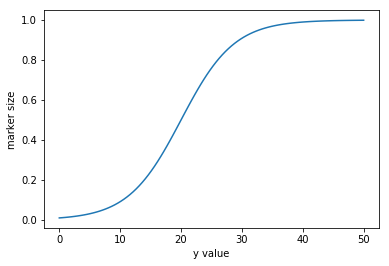

# Penalty map
Basic idea is that, when ground truth pixels are missing (false negative), they result in more penalties as they are further from prediction pixels. In other words, if missing pixels are around your prediction pixels, it would 

[[ 0.          1.          1.41421356  2.23606798  3.        ]
 [ 0.          0.          1.          2.          2.        ]
 [ 0.          1.          1.41421356  1.41421356  1.        ]
 [ 0.          1.          1.41421356  1.          0.        ]
 [ 0.          1.          1.          0.          0.        ]]


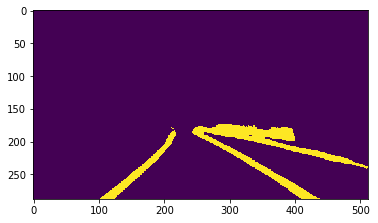

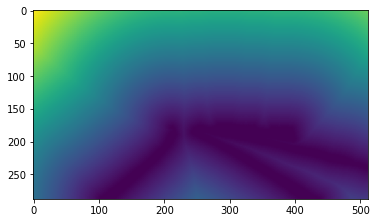

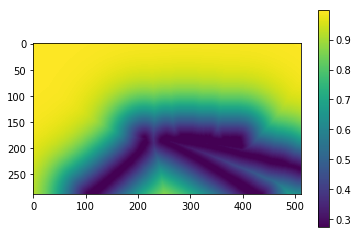

In [96]:
a = np.array(([0,1,1,1,1],
              [0,0,1,1,1],
              [0,1,1,1,1],
              [0,1,1,1,0],
              [0,1,1,0,0]))
print(distance_transform_edt(a))
penalty_map = distance_transform_edt(1 - submission)
plt.imshow(submission); plt.show()
plt.imshow(penalty_map); plt.show()
f = np.vectorize(sigmoid)
penalty_wmap = f(penalty_map, X5=30., X9=100.)
plt.imshow(penalty_wmap); plt.colorbar(); plt.show()